# Solving PDEs with Wavelets
The simplest wavelet is the Haar wavelet. It is not much used in practice but it is convenient to fix ideas. The Haar function is given by

$$\psi(x)=\begin{cases}1,&x \in [0,1)\cr -1,&x \in [\frac{1}{2},1)\cr 0,&\text{otherwise}\end{cases}$$

In [1]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

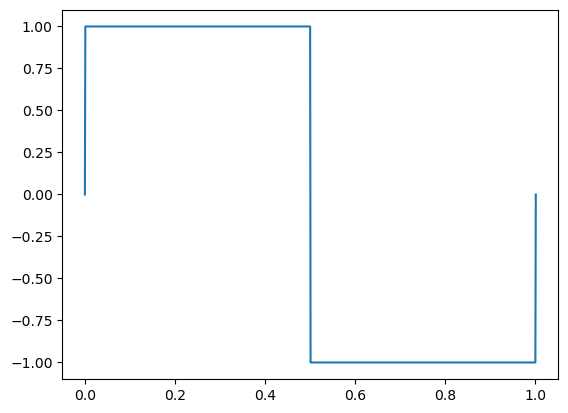

In [2]:
w = pywt.Wavelet('haar')
res = w.wavefun(level=10)
phi, psi, x = res[0], res[1], res[-1]

fig, ax = plt.subplots()
ax.plot(x, psi);

The location in the domain and the range of this *mother wavelet* function can be conrolled by a translation index $k$ and a dilation index $j$, respectively.

$$\psi_{j,k}(x)=2^{j/2}\psi(2^{j}x-k)$$

A wavelet system is fully defined once a *scaling function*, or *father wavelet*, is defined. The scaling function ensures that the orthonormal basis covers the original space of a function without having to use an infinite number of mother wavelets. The father wavelet for the Haar system is 

$$\phi(x)=I_{[0,1)}(x)$$

where $I_A(x)$ is an indicator function that equals 1 if $x$ is in the set $A$. You can see that any dilation and translation can cover the original function space. While the Haar function is a good introduction, the rest of the code will use the most nearly symmetric Debauchies wavelet with N=8.

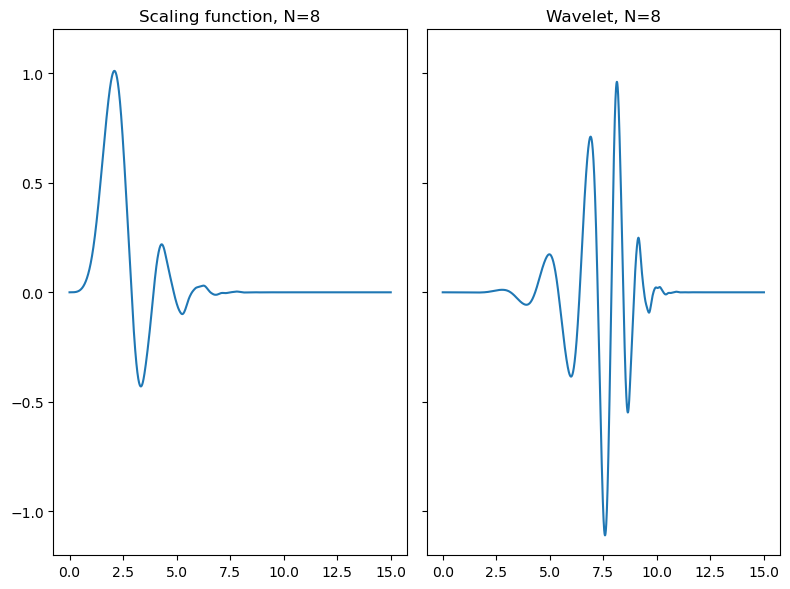

In [3]:
db8 = pywt.Wavelet('db8')
scaling, wavelet, x = db8.wavefun()

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,6))
ax1, ax2 = axes

ax1.plot(x, scaling);
ax1.set_title('Scaling function, N=8');
ax1.set_ylim(-1.2, 1.2);

ax2.set_title('Wavelet, N=8');
ax2.tick_params(labelleft=False);
ax2.plot(x, wavelet);

fig.tight_layout()

We start using wavelet analysis to recover the unknown function $f$ from noisy data

$$y_i = f(x_i) + e_i, i \in \left\{1,\dots,n\right\}$$

with $x_i = i/n$ without loss of generality and $e_i \sim N(0,\sigma^2)$. The expansion of the function $f$ as a finite sum of wavelets can be achieved as

$$f_J(x) = \alpha\phi(x) + \sum_{j=0}^{J-1}\sum_{k=0}^{2^j-1}\beta_{jk}\psi_{jk}(x)$$

where

$$\alpha=\int_0^1f(x)\phi(x)dx\text{, }\beta_{jk}=\int_0^1f(x)\psi_{jk}(x)dx.$$ 

$\alpha$ and $\beta_jk$ are called the scaling coefficients and the detail coefficients, respectively. The basic idea is that the detail coefficients capture the coarser details of the function while the scaling, or smoothing, coefficients capture the overall functional form.

Donoho and Johnstone use four functions that mimic properties of empirical data in domains where wavelets might be useful, Bumps, Blocks, HeaviSine, and Doppler. For completeness, they are defined here.

In [4]:
def doppler(x):
    """
    Parameters
    ----------
    x : array-like
        Domain of x is in (0,1]
 
    """
    if not np.all((x >= 0) & (x <= 1)):
        raise ValueError("Domain of doppler is x in (0,1]")
    return np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+.05))
 
def blocks(x):
    """
    Piecewise constant function with jumps at t.
 
    Constant scaler is not present in Donoho and Johnstone.
    """
    K = lambda x : (1 + np.sign(x))/2.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2]]).T
    return 3.655606 * np.sum(h*K(x-t), axis=0)
 
def bumps(x):
    """
    A sum of bumps with locations t at the same places as jumps in blocks.
    The heights h and widths s vary and the individual bumps are of the
    form K(t) = 1/(1+|x|)**4
    """
    K = lambda x : (1. + np.abs(x)) ** -4.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 2.1, 4.2]]).T
    w = np.array([[.005, .005, .006, .01, .01, .03, .01, .01, .005, .008, .005]]).T
    return np.sum(h*K((x-t)/w), axis=0)
 
def heavisine(x):
    """
    Sinusoid of period 1 with two jumps at t = .3 and .72
    """
    return 4 * np.sin(4*np.pi*x) - np.sign(x - .3) - np.sign(.72 - x)

In [5]:
x = np.linspace(0,1,2**11)
dop = doppler(x)
blk = blocks(x)
bmp = bumps(x)
hsin = heavisine(x)

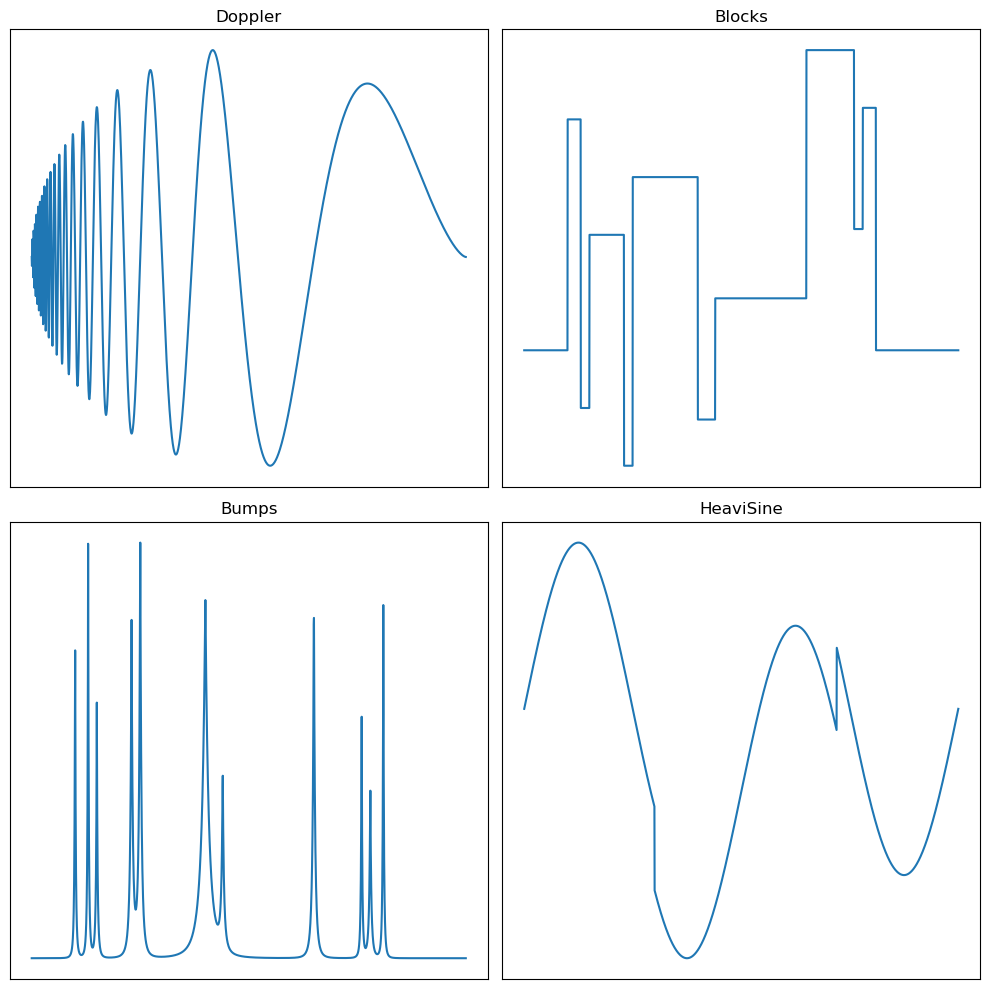

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.plot(x,dop)
ax1.set_title("Doppler")

ax2.plot(x,blk)
ax2.set_title("Blocks")

ax3.plot(x,bmp)
ax3.set_title("Bumps")

ax4.set_title("HeaviSine")
ax4.plot(x,hsin)

for ax in fig.axes:
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, 
                   top=False, left=False, right=False)

fig.tight_layout();

The wavelet coefficients fully describe some data. First, generate some data from the noisy doppler function and apply a discrete wavelet transform to recover the smoothing and detail coefficients, then have a look at a common diagnostic plot of the wavelet coefficients using `coef_pyramid_plot`.

In [7]:
def coef_pyramid_plot(coefs, first=0, scale='uniform', ax=None):
    """
    Parameters
    ----------
    coefs : array-like
        Wavelet Coefficients. Expects an iterable in order Cdn, Cdn-1, ...,
        Cd1, Cd0.
    first : int, optional
        The first level to plot.
    scale : str {'uniform', 'level'}, optional
        Scale the coefficients using the same scale or independently by
        level.
    ax : Axes, optional
        Matplotlib Axes instance

    Returns
    -------
    Figure : Matplotlib figure instance
        Either the parent figure of `ax` or a new pyplot.Figure instance if
        `ax` is None.
    """

    if ax is None:
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, axisbg='lightgrey')
    else:
        fig = ax.figure

    n_levels = len(coefs)
    n = 2**(n_levels - 1) # assumes periodic

    if scale == 'uniform':
        biggest = [np.max(np.abs(np.hstack(coefs)))] * n_levels
    else:
        # multiply by 2 so the highest bars only take up .5
        biggest = [np.max(np.abs(i))*2 for i in coefs]

    for i in range(first,n_levels):
        x = np.linspace(2**(n_levels - 2 - i), n - 2**(n_levels - 2 - i), 2**i)
        ymin = n_levels - i - 1 + first
        yheight = coefs[i]/biggest[i]
        ymax = yheight + ymin
        ax.vlines(x, ymin, ymax, linewidth=1.1)

    ax.set_xlim(0,n)
    ax.set_ylim(first - 1, n_levels)
    ax.yaxis.set_ticks(np.arange(n_levels-1,first-1,-1))
    ax.yaxis.set_ticklabels(np.arange(first,n_levels))
    ax.tick_params(top=False, right=False, direction='out', pad=6)
    ax.set_ylabel("Levels", fontsize=14)
    ax.grid(True, alpha=.85, color='white', axis='y', linestyle='-')
    ax.set_title('Wavelet Detail Coefficients', fontsize=16,
            position=(.5,1.05))
    fig.subplots_adjust(top=.89)

    return fig

Generate the data and get the coefficients using the multilevel discrete wavelet transform. Plot the true coefficients and the noisy ones.

/Users/heltai/anaconda3/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 11 is too high: all coefficients will experience boundary effects.
  warnings.warn(


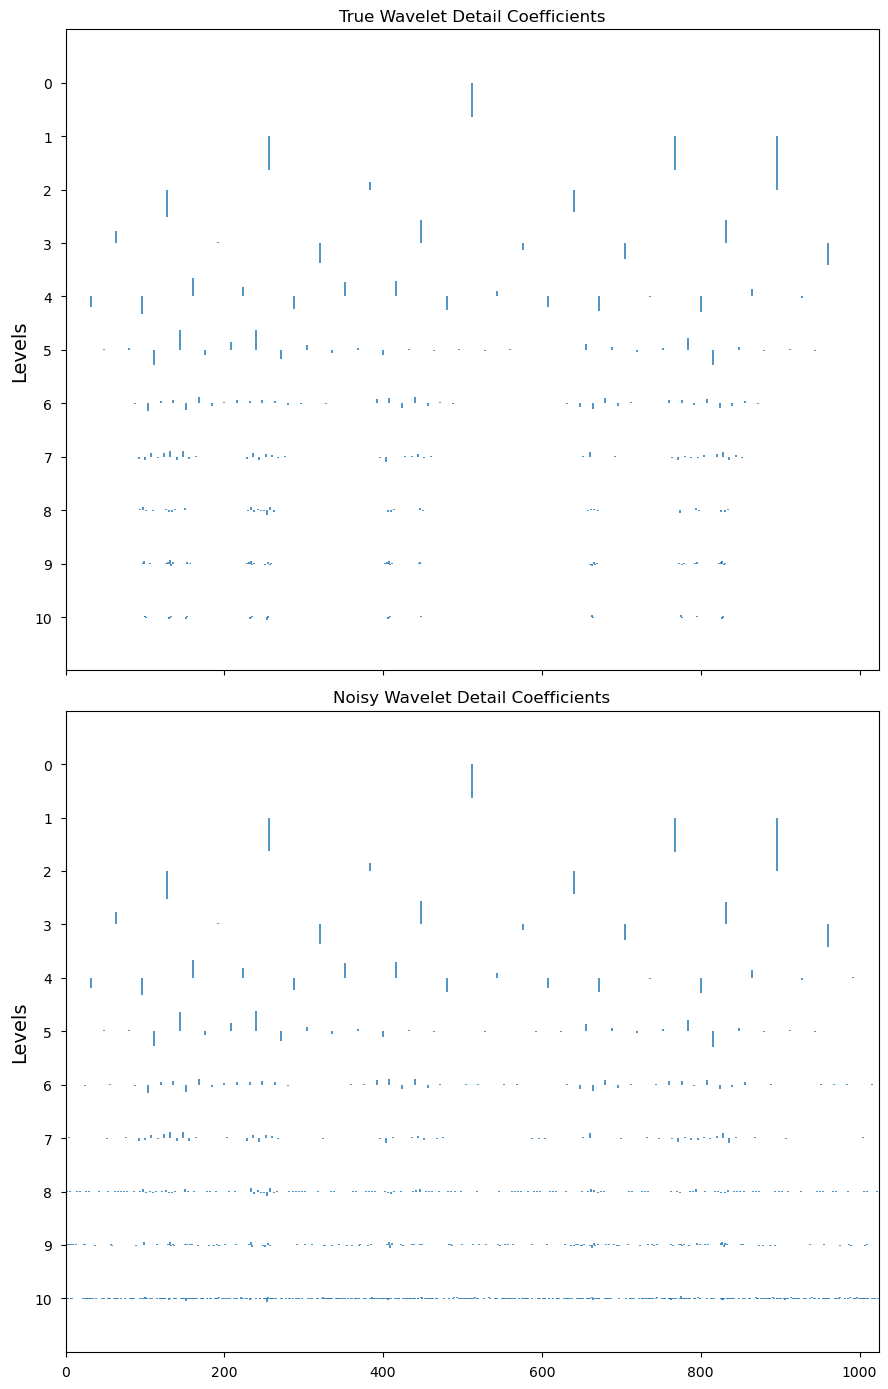

In [8]:
from scipy import stats
import numpy as np

np.random.seed(12345)
blck = blocks(np.linspace(0,1,2**11))
nblck = blck + stats.norm().rvs(2**11)

true_coefs = pywt.wavedec(blck, 'db8', level=11, mode='per')
noisy_coefs = pywt.wavedec(nblck, 'db8', level=11, mode='per')

fig, axes = plt.subplots(2, 1, figsize=(9,14), sharex=True)

fig = coef_pyramid_plot(true_coefs[1:], ax=axes[0]) # omit smoothing coefs
axes[0].set_title("True Wavelet Detail Coefficients");

fig = coef_pyramid_plot(noisy_coefs[1:], ax=axes[1]) ;
axes[1].set_title("Noisy Wavelet Detail Coefficients");

fig.tight_layout()

Notice that most of the coefficients of the true signal are zero. This is the idea of *sparseness*, most functions, smooth or otherwise, have a sparse respresentation in a wavelet basis. The detail coefficients are non-zero where the block function is not flat. The detail coefficients of the noisy signal have many more non-zero coefficients at the higher resolutions from the added noise. To recover the signal from the noisy coefficients, you *threshold* the coefficients. Essentially, thresholding sets many of the coefficients to zero by assuming that they are noise. There are a number of ways to go about performing thresholding. I will simply apply soft thresholding using a given threshold.

In [9]:
tol = 5

denoised = noisy_coefs[:]

denoised[1:] = (pywt.threshold(a, value=tol, mode='soft') for a in denoised[1:])

We can recover the signal by applying the inverse discrete wavelet transform to the thresholded coefficients.

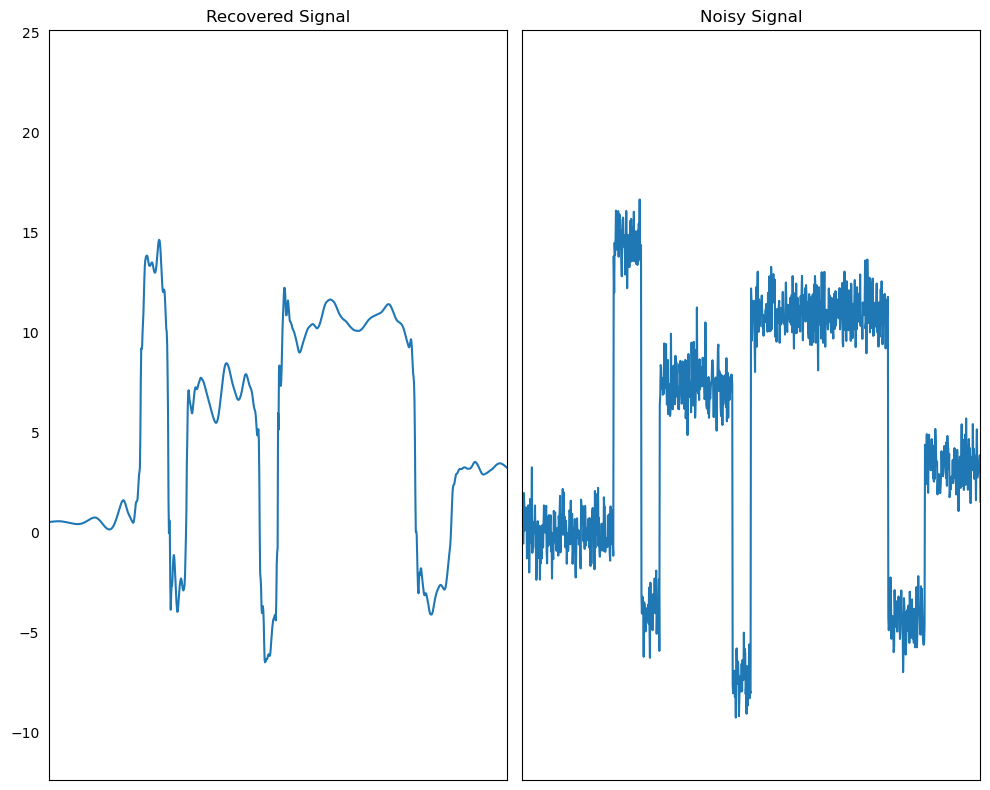

In [10]:
signal = pywt.waverec(denoised, 'db8', mode='per')

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True,
                         figsize=(10,8))
ax1, ax2 = axes

ax1.plot(signal)
ax1.set_xlim(0,2**10)
ax1.set_title("Recovered Signal")
ax1.margins(.1)

ax2.plot(nblck)
ax2.set_title("Noisy Signal")

for ax in fig.axes:
    ax.tick_params(labelbottom=False, top=False, bottom=False, left=False, 
                 right=False)
    
fig.tight_layout()

# Solving PDEs - Optimal preconditioning
Now let's apply this to a PDE.

We solve 

$$
-u'' = f \quad \text{ in } (0,1)
$$

with 

$$
u(0) = u(1) = 0
$$

Using finite differences, i.e., split the domain in $n$ equal intervals, and solve 

$$
-D^2 u^k := \frac{-u^{k-1}+2u^k-u^{k+1}}{h^2} = f^k = f(x^k)
$$

where $x^k = k*h$ and $h=1/(n-1)$.

We pick $n$ to be a power of two, to compute FWT.

In [11]:
n = 1024
x, h = np.linspace(0,1,n,retstep=True)

# Central finite differences matrix
A = (2*np.diag(np.ones((n)))-np.diag(np.ones((n-1)),-1)-np.diag(np.ones((n-1)),+1))/h**2

In [12]:
# Impose boundary conditions
A[0,:] = 0;
A[:,0] = 0;
A[0,0] = 1/h**2;

A[-1,:] = 0;
A[:,-1] = 0;
A[-1,-1] = 1/h**2;

In [13]:
# Forcing term
b = np.exp(5*x)
b[0] = b[-1] = 0

In [14]:
u = np.linalg.solve(A,b)

In [15]:
from scipy.sparse.linalg import cg

it = 0
def count(x):
    globals()['it'] +=1

u, info = cg(A, b, tol=1e-10, maxiter=2*n, callback=count)

In [16]:
print("Number of iterations:", it)

Number of iterations: 1023


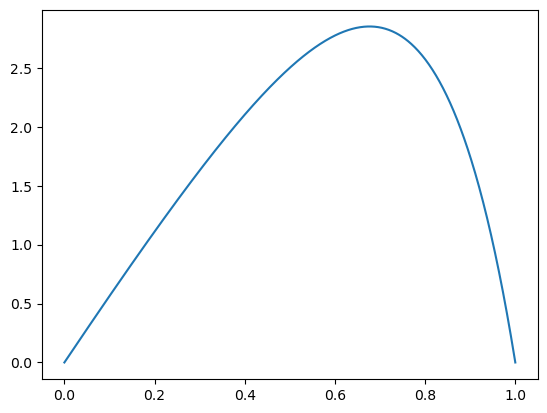

In [17]:
plt.plot(x, u)

# Wavelet and inverse Wavelet operators

In [18]:
# Compute "brute force" the DWT operator
wavelet = 'rbio2.4'
wavelet = 'haar'
wavelet = 'db2'
F = np.zeros((n,n))
Finv = np.zeros((n,n))

u = np.random.rand(n)
u_coeffs = pywt.wavedec(u, wavelet, mode='per')
# Check that the n we chose is fine.
lens = [len(c) for c in u_coeffs]
assert sum(lens) == n

In = np.eye(n)
for i in range(n):
    ei = In[:,i]
    coeffs = pywt.wavedec(ei, wavelet, mode='per')
    ci = np.hstack(coeffs)
    F[:,i] = ci
    coeffs = np.split(ei, np.cumsum(lens)[:-1])
    Finv[:,i] = pywt.waverec(coeffs, wavelet, mode='per')


In [19]:
# Check that we have the identity
np.max(abs(Finv.dot(F)-In))

2.220446049250313e-16

In [20]:
# Check that using F is the same as computing the DWT
dwtu = np.hstack(pywt.wavedec(u, wavelet, mode='per'))
Fdwtu = F.dot(u)
np.max(abs(dwtu-Fdwtu))

2.6645352591003757e-15

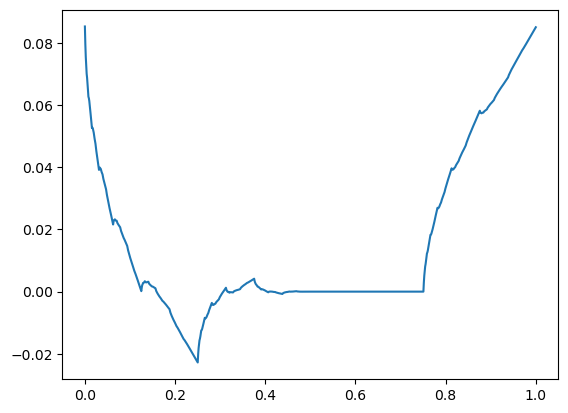

In [21]:
# Let's look at the first coefficients
plt.plot(x, Finv[:,0])

In [22]:
coeffs = np.split(Fdwtu, np.cumsum(lens)[:-1])
[len(c) for c in coeffs]

[4, 4, 8, 16, 32, 64, 128, 256, 512]

# Scaling matrix

The scaling matrix is defined as 

$$
w_\lambda := 2^{js} \quad\text{ for } \quad\lambda \in \Lambda_j
$$


In [23]:
s = 1.0
wlambda = [2**(j*s) for j in range(-1,len(coeffs)-1)]

In [24]:
D_diag = np.hstack([wlambda[j]*np.ones((lens[j],)) for j in range(len(lens))])
D = np.diag(D_diag)
Dinv = np.diag(1/D_diag)

# Change of basis

From vectors of scaling coefficients at level $j$, 

$$
v = V^\nu \phi_\nu, \qquad u = U^\nu \phi_\nu, \qquad \nu \in K_j
$$

we move to vectors of wavelet coefficients

$$
u = u^\lambda \psi_\lambda, \qquad v = v^\lambda \psi_\lambda \quad \text{for}\quad \lambda \in \Lambda_h = \cup_{k=-1}^j \Lambda_k, \qquad \Lambda_{-1} \equiv K_0
$$

through the DWT operator $\Gamma = F V$ and $\Theta = F U$ where $\Gamma = \{u^\lambda\}_{\lambda \in \Lambda_h}$ and $\Theta =  \{v^\lambda\}_{\lambda \in \Lambda_h}$.

Then

$$
V = F^{-1} \Gamma, U = F^{-1}\Theta
$$

$$ 
\Gamma^T R \Theta = V^T A U = (\Gamma^T F^{-T}) A (F^{-1} \Theta) \qquad \Longrightarrow\qquad R = F^{-T} A F^{-1}
$$

$R$ admits the optimal diagonal preconditioner $D^{-1}$ where 

$$
D_{\lambda\lambda'} = w_\lambda \delta_{\lambda \lambda'} = 2^{js} \qquad \lambda \in \Lambda_j
$$
that is, the operator 
$$
E := F^{-1}D^{-1}
$$
is such that 
$$
\kappa(E^T A E) \sim 1
$$
and we can solve efficiently using CG the system 

$$
Au = b
$$

by multiplying both sides by $E^T$, and setting $u=Ey$:

$$
E^T A E y = E^T b
$$
We then solve for the split-preconditioned system $(E^T A E) y = b$, and recover the solution $u$ by $u = E y$

In [25]:
E = Finv.dot(Dinv)

np.linalg.cond(D), np.linalg.cond(F), np.linalg.cond(E)

(256.0, 1.0000000000000036, 256.00000000002365)

In [26]:
EtAE = E.T.dot(A).dot(E)

In [27]:
np.linalg.cond(EtAE), np.linalg.cond(A)

(5009.989664194721, 424141.56132481137)

In [28]:
it = 0
def count(x):
    globals()['it'] +=1
    
Etb = E.T.dot(b)

y, info = cg(EtAE, Etb, tol=1e-10, maxiter=20*n, callback=count)
print("Number of preconditioned iterations: ", it)

Number of preconditioned iterations:  72


In [29]:
u = E.dot(y)

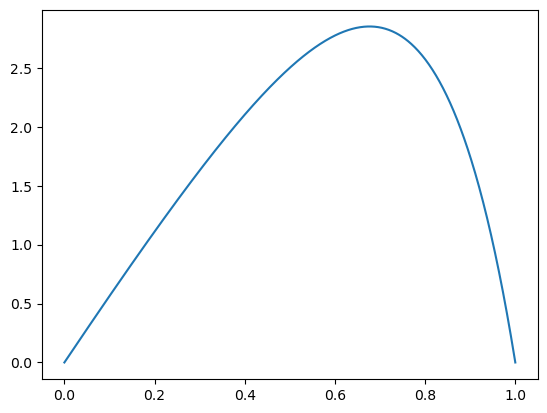

In [30]:
plt.plot(x, u)